# Fantasy Football Lineups Generator (Euro 2020)
* Data was collected from various sources including eurofantasy.sport5 (stats, names, prices), whoscored (stats of previouse tournaments), oddschecker (betting odds) and more.

sources:

https://eurofantasy.sport5.co.il/

https://www.whoscored.com/Regions/247/Tournaments/124/International-European-Championship

https://www.oddschecker.com/football/euro-2020/winner

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Load Data and review it
*pre-tournament

### Teams data
1. name_h - team hebraw name (str)
2. name_e - team english name (str)
3. theguardian_pr - power ranking extracted from "The Guardian" website. (int: 1->24)
4. fifa_ranking - ordered list of teams by fifa ranking. (int: 1->24)
5. reddit1_pr - power ranking extracted from a sub-reddit. (int: 1->24) 
6. reddit2_pr - another power ranking extracted from a sub-reddit. (int: 1->24)
7. my_pr - my personal power ranking of teams. (int: 1->24)
8. bets_odds - average betting odds (for winning the tournament) extracted from oddschecker. (float: >0 )
9. form_last6 - from of the team in the last 6 games (from left to right), W-Win, D-Draw, L-Lose. (str)
10. gfpg - Goals For per Game - qualifiers round. (float: >=0)
10. gapg - Goals Against per Game - qualifiers round. (float: >=0)

In [2]:
teams_df = pd.read_csv('data/teams.csv', encoding='utf-8')
teams_df.head()

,name_h,name_e,theguardian_pr,fifa_ranking,reddit1_pr,reddit2_pr,my_pr,bets_odds,form_last6,gfpg,gapg
0,צרפת,France,1,2,1,1,2,4.68,WWWDWW,2.500,0.600
1,אנגליה,England,4,3,8,9,1,5.03,WWWWWL,4.625,0.750
2,בלגיה,Belgium,3,1,2,6,5,6.20,WDWWWW,4.000,0.300
3,ספרד,Spain,10,5,5,3,7,7.87,WWDWDD,3.100,0.500
4,גרמניה,Germany,2,8,9,4,3,7.93,DLWWLW,3.750,0.875


### Players data
1. name_h - player hebraw name (str)
2. name_e - player english name (str)
3. team - player's team name - hebraw (str)
4. is_penalty_taker - indicates if the player is his team penaly taker. (int: binary - 0/1)
5. is_starter - indicates if player is in the starting XI of its team. (int: binary - 0/1) ** NOT IN USE DUE TO PARTIAL DATA **

In [3]:
players_df = pd.read_csv('data/players.csv', encoding='utf-8')  # TODO - add players
players_df.head()

,name_h,name_e,team,is_penalty_taker,is_starter
0,אלכסנדר שלאגר,Alexander Schlager,אוסטריה,0,1
1,דניאל באכמן,NaN,אוסטריה,0,0
2,פאבאו פרבאן,Pavao Pervan,אוסטריה,0,0
3,אלכסנדר דרגוביץ',Aleksandar Dragovic,אוסטריה,0,1
4,אנדראס אולמר,Andreas Ulmer,אוסטריה,0,0


### Players stats (from whoscored.com)
*all stats below are calculated on last 2 international tournaments.
1. Player - player name in english (str)
2. Apps - appearances (int: >=0)
3. Mins - minutes played (int: >=0)
3. Goals
4. Assists
5. SpG - Shots per Game
6. Rating - whoscored rating 
7. Apps_percentage - appearances percentage out of the maximum number of appearances for the team.
8. Mins_percentage - minutes percentage out of the maximum number of minutes played for the team.
9. Goals_percentage - goals scored by player out of all the goals of the team.
10. Assists_percentage - goals assisted by player out of all the goals assisted of the team.
11. GnA_percentage - goals scored and assisted by player out of all the goals scored and assisted of the team.

In [4]:
players_stats_df = pd.read_csv('data/players_stats.csv', encoding='utf-8')
convert_dict = {'Player': str,
                'Apps': int,
                'Mins': int,
                'Goals': int,
                'Assists': int,
                'SpG': float,
                'Rating': float,
                'Apps_percentage': float,
                'Mins_percentage': float,
                'Goals_percentage': float,
                'Assists_percentage': float,
                'GnA_percentage': float}
players_stats_df = players_stats_df.astype(convert_dict)
players_stats_df.head()

,Player,Apps,Mins,Goals,Assists,SpG,Rating,Apps_percentage,Mins_percentage,Goals_percentage,Assists_percentage,GnA_percentage
0,Adrien Rabiot,7,633,0,1,1.00,7.025,0.778,0.781,0.000,0.125,0.045
1,Anthony Martial,4,332,0,2,1.85,6.850,0.444,0.410,0.000,0.250,0.091
2,Antoine Griezmann,9,760,4,1,1.85,7.490,1.000,0.938,0.286,0.125,0.227
3,Benjamin Pavard,5,450,1,0,0.60,7.335,0.556,0.556,0.071,0.000,0.045
4,Clément Lenglet,3,270,0,0,0.75,6.910,0.333,0.333,0.000,0.000,0.000


### Load players game data

In [5]:
round1_file_path = 'data/raw/2021-06-06-r1.html'
data = pd.read_html(round1_file_path)

In [6]:
gaolkeepers_columns_renames = {"שוער": "name", "מחיר": "price", "נק’": "points"}
gaolkeepers_df = data[7].rename(columns=gaolkeepers_columns_renames)
gaolkeepers_df['position'] = 'GK'
del gaolkeepers_df['Unnamed: 3']

In [7]:
defenders_columns_renames = {"הגנה": "name", "מחיר": "price", "נק’": "points"}
defenders_df = data[8].rename(columns=defenders_columns_renames)
defenders_df['position'] = 'D'
del defenders_df['Unnamed: 3']

In [8]:
midfielders_columns_renames = {"קישור": "name", "מחיר": "price", "נק’": "points"}
midfielders_df = data[9].rename(columns=midfielders_columns_renames)
midfielders_df['position'] = 'M'
del midfielders_df['Unnamed: 3']

In [9]:
forwards_columns_renames = {"התקפה": "name", "מחיר": "price", "נק’": "points"}
forwards_df = data[10].rename(columns=forwards_columns_renames)
forwards_df['position'] = 'FW'
del forwards_df['Unnamed: 3']

In [10]:
players_gamedata_df = pd.concat([gaolkeepers_df, defenders_df, midfielders_df, forwards_df], ignore_index=True)
players_gamedata_df['team'] = players_gamedata_df['name'].apply(lambda x: ((x.split('('))[1].split(")"))[0])
players_gamedata_df['name'] = players_gamedata_df['name'].apply(lambda x: ((x.split('('))[0])[:-1])
players_gamedata_df['price'] = players_gamedata_df['price'].apply(lambda x: (x.split('.'))[0]).astype('int')

In [11]:
players_gamedata_df.head()

,name,price,points,position,team
0,הוגו לוריס,10,0,GK,צרפת
1,אונאי סימון,9,0,GK,ספרד
2,טיבו קורטואה,9,0,GK,בלגיה
3,מנואל נוייר,9,0,GK,גרמניה
4,ג'אנלואיג'י דונארומה,8,0,GK,איטליה


### Load matches data (rounds 1 to 3)

In [12]:
matches_columns_renames = {"תאריך": "date", "שעה": "hour", "קבוצה מארחת": "home_team", "תוצאה": "score", "קבוצה אורחת": "away_team", "סקירה": "review"}
round1_matches_df = data[0].rename(columns=matches_columns_renames)
round1_matches_df['date'] = pd.to_datetime(round1_matches_df['date'], format="%d.%m.%Y")
del round1_matches_df['hour']
del round1_matches_df['review']

In [13]:
round2_file_path = 'data/raw/2021-06-06-r2.html'
data = pd.read_html(round2_file_path)
round2_matches_df = data[0].rename(columns=matches_columns_renames)
round2_matches_df['date'] = pd.to_datetime(round2_matches_df['date'], format="%d.%m.%Y")
del round2_matches_df['hour']
del round2_matches_df['review']

In [14]:
round3_file_path = 'data/raw/2021-06-06-r3.html'
data = pd.read_html(round3_file_path)
round3_matches_df = data[0].rename(columns=matches_columns_renames)
round3_matches_df['date'] = pd.to_datetime(round3_matches_df['date'], format="%d.%m.%Y")
del round3_matches_df['hour']
del round3_matches_df['review']

In [15]:
round3_matches_df.head()

,date,home_team,score,away_team
0,2021-06-20,איטליה,---,וויילס
1,2021-06-20,שווייץ,---,טורקיה
2,2021-06-21,אוקראינה,---,אוסטריה
3,2021-06-21,צפון מקדוניה,---,הולנד
4,2021-06-21,פינלנד,---,בלגיה


## Feature engineering
* I'll create a general PR (power rank) score for each team based on combination of other power ranks sources, betting odds and form.
* based on the above and considering GFpG (Goals For per Game) and GApG (Goals Against per Game) i'll try to estimate the score for each match.
* based on the estimated score of each match and the scoring rules of the game, i'll try to estimate how much game points each player "worth" every round.

### Team features

* form - accumulated points according to form of last 6 matches. normalized to (0,1). higher is better.

In [16]:
teams_df['form'] =  3 * teams_df['form_last6'].str.count('W') +  teams_df['form_last6'].str.count('D')
minimum = teams_df['form'].min()
maximum = teams_df['form'].max()
teams_df['form'] = (teams_df['form'] - minimum)/(maximum - minimum)
teams_df.drop('form_last6', axis='columns', inplace=True)

* power_rank_avg - average of 5 different power ranking (detailed above). normalized to (0,1). higher is better.

In [17]:
power_rank_columns = ["theguardian_pr", "fifa_ranking", "reddit1_pr", "reddit2_pr", "my_pr"]
teams_df['power_rank_avg'] = teams_df[power_rank_columns].mean(axis=1)
minimum = teams_df['power_rank_avg'].min()
maximum = teams_df['power_rank_avg'].max()
teams_df['power_rank_avg'] = (teams_df['power_rank_avg'] - minimum)/(maximum - minimum)
teams_df['power_rank_avg'] = 1 - teams_df['power_rank_avg']
teams_df.drop(power_rank_columns, axis='columns', inplace=True)

* bets_odds - average betting odds (detailed above). normalized to (0,1). higher is better.

In [18]:
minimum = teams_df['bets_odds'].min()
maximum = teams_df['bets_odds'].max()
teams_df['bets_odds'] = (teams_df['bets_odds'] - minimum)/(maximum - minimum)
teams_df['bets_odds'] = 1 - teams_df['bets_odds']

* weighted_sum_pr - power rank that is a wighted sum of form, power_rank_avg and bets_odds. note that the weight of bet odds is significantly higher. it's probably the most accurate representation of the ranking between teams.

In [19]:
w_bets_odds = 0.5
w_power_rank_avg = 0.3
w_form = 0.2
w_power = 1.4
teams_df['weighted_sum'] = (w_bets_odds * teams_df['bets_odds']) + (w_power_rank_avg * teams_df['power_rank_avg']) + (w_form * teams_df['form'])
teams_df['weighted_sum'] = np.power(teams_df['weighted_sum'], w_power)

* gfpg, gapg - Goals For/Against per Game. I tweeked it to represent more accurately the harder match-ups in the tournament (relitivly to qulifiers, where gfpg and gapg were recorded). 

In [20]:
teams_df['gfpg'] = 0.8 * teams_df['gfpg']
teams_df['gapg'] = 1.2 * teams_df['gapg']

In [21]:
cols = ['bets_odds', 'form', 'power_rank_avg', 'weighted_sum']
teams_df[cols] = teams_df[cols].round(3)
teams_df.head()

,name_h,name_e,bets_odds,gfpg,gapg,form,power_rank_avg,weighted_sum
0,צרפת,France,1.000,2.00,0.72,0.846,1.000,0.957
1,אנגליה,England,0.999,3.70,0.90,0.769,0.838,0.869
2,בלגיה,Belgium,0.997,3.20,0.36,0.846,0.910,0.918
3,ספרד,Spain,0.993,2.48,0.60,0.538,0.793,0.786
4,גרמניה,Germany,0.993,3.00,1.05,0.385,0.829,0.760


In [22]:
teams_df.describe()

,bets_odds,gfpg,gapg,form,power_rank_avg,weighted_sum
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,0.757958,1.905556,0.989167,0.461500,0.500000,0.541958
std,0.306190,0.750427,0.408964,0.290342,0.300565,0.288324
min,0.000000,1.000000,0.360000,0.000000,0.000000,0.028000
25%,0.721750,1.295000,0.690000,0.211750,0.274500,0.390750
50%,0.852500,1.770000,0.930000,0.500000,0.495500,0.586000
75%,0.989000,2.325000,1.110000,0.634250,0.802000,0.766500
max,1.000000,3.700000,2.000000,1.000000,1.000000,0.957000


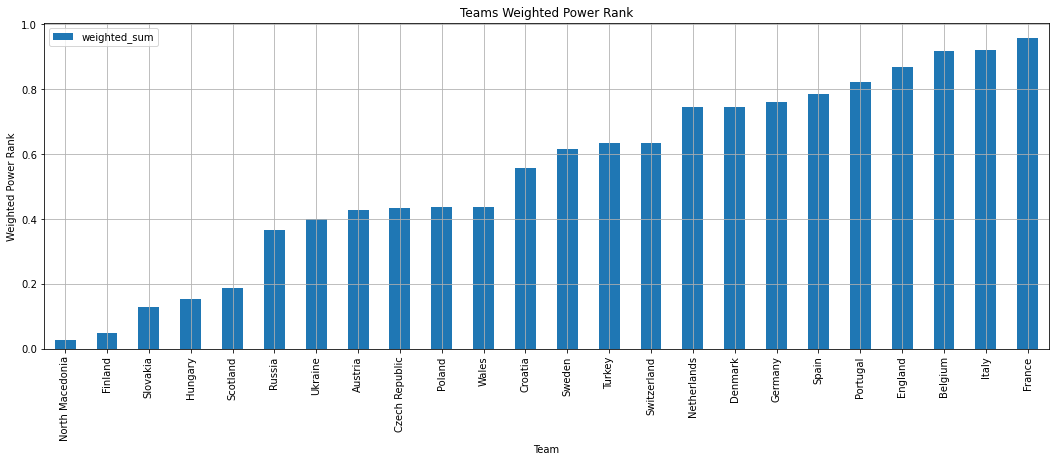

In [23]:
teams_df.sort_values("weighted_sum", inplace=True)
teams_df.plot(x="name_e", y=["weighted_sum"], kind="bar", figsize=(18,6));
plt.grid();
plt.xticks(rotation=90);
plt.title('Teams Weighted Power Rank');
plt.xlabel('Team');
plt.ylabel('Weighted Power Rank');

### Get opponents for every round and estimate match outcome

In [24]:
pr_diff_wight = 1.3
def calc_GF(x):
    numenator = x.gfpg + x.opponent_gapg
    denuminator = 2 - pr_diff_wight * x.pr_diff
    return numenator / denuminator

def calc_GA(x):
    numenator = x.gapg + x.opponent_gfpg
    denuminator = 2 + pr_diff_wight * x.pr_diff
    return numenator / denuminator

#### Round 1 matches

In [25]:
opponents1_df = round1_matches_df[['home_team', 'away_team']].set_index('home_team')
opponents2_df = round1_matches_df[['home_team', 'away_team']].set_index('away_team')
opponents_round1_df = pd.concat([opponents1_df, opponents2_df])
opponents_round1_df['opponent'] = opponents_round1_df.fillna('').sum(axis=1)
opponents_round1_df.drop(columns=['home_team', 'away_team'], inplace=True)

In [26]:
matches_round1_df = opponents_round1_df.merge(teams_df, left_index=True, right_on='name_h').set_index('name_h')
matches_round1_df.drop(columns=['name_e', 'bets_odds', 'power_rank_avg', 'form'], inplace=True)
matches_round1_df.rename(columns={'weighted_sum': 'pr'}, inplace=True)
matches_round1_df['opponent_pr'] = matches_round1_df.apply(lambda row: matches_round1_df.loc[row['opponent']].get('pr'), axis=1)
matches_round1_df['opponent_gfpg'] = matches_round1_df.apply(lambda row: matches_round1_df.loc[row['opponent']].get('gfpg'), axis=1)
matches_round1_df['opponent_gapg'] = matches_round1_df.apply(lambda row: matches_round1_df.loc[row['opponent']].get('gapg'), axis=1)
matches_round1_df['pr_diff'] = matches_round1_df['pr'] - matches_round1_df['opponent_pr']
matches_round1_df.drop(columns=['pr', 'opponent_pr'], inplace=True)

In [27]:
matches_round1_df['pred_GF'] = matches_round1_df.apply(lambda row: calc_GF(row), axis=1)
matches_round1_df['pred_GA'] = matches_round1_df.apply(lambda row: calc_GA(row), axis=1)
matches_round1_df['pred_score'] = matches_round1_df.apply(lambda row: (np.floor(row.pred_GF).astype(int), np.floor(row.pred_GA).astype(int)), axis=1)
matches_round1_df.head()

,opponent,gfpg,gapg,opponent_gfpg,opponent_gapg,pr_diff,pred_GF,pred_GA,pred_score
name_h,,,,,,,,,
טורקיה,איטליה,1.44,0.36,2.96,0.48,-0.287,0.809068,2.040691,"(0, 2)"
וויילס,שווייץ,1.00,0.90,1.90,0.90,-0.197,0.842161,1.605597,"(0, 1)"
דנמרק,פינלנד,2.30,0.90,1.28,1.20,0.699,3.207184,0.749476,"(3, 0)"
בלגיה,רוסיה,3.20,0.36,2.00,0.96,0.552,3.243918,0.868413,"(3, 0)"
אנגליה,קרואטיה,3.70,0.90,1.70,1.05,0.313,2.981608,1.080228,"(2, 1)"


#### Round 2 matches

In [28]:
opponents1_df = round2_matches_df[['home_team', 'away_team']].set_index('home_team')
opponents2_df = round2_matches_df[['home_team', 'away_team']].set_index('away_team')
opponents_round2_df = pd.concat([opponents1_df, opponents2_df])
opponents_round2_df['opponent'] = opponents_round2_df.fillna('').sum(axis=1)
opponents_round2_df.drop(columns=['home_team', 'away_team'], inplace=True)

In [29]:
matches_round2_df = opponents_round2_df.merge(teams_df, left_index=True, right_on='name_h').set_index('name_h')
matches_round2_df.drop(columns=['name_e', 'bets_odds', 'power_rank_avg', 'form'], inplace=True)
matches_round2_df.rename(columns={'weighted_sum': 'pr'}, inplace=True)
matches_round2_df['opponent_pr'] = matches_round2_df.apply(lambda row: matches_round2_df.loc[row['opponent']].get('pr'), axis=1)
matches_round2_df['opponent_gfpg'] = matches_round2_df.apply(lambda row: matches_round2_df.loc[row['opponent']].get('gfpg'), axis=1)
matches_round2_df['opponent_gapg'] = matches_round2_df.apply(lambda row: matches_round2_df.loc[row['opponent']].get('gapg'), axis=1)
matches_round2_df['pr_diff'] = matches_round2_df['pr'] - matches_round2_df['opponent_pr']
matches_round2_df.drop(columns=['pr', 'opponent_pr'], inplace=True)

In [30]:
matches_round2_df['pred_GF'] = matches_round2_df.apply(lambda row: calc_GF(row), axis=1)
matches_round2_df['pred_GA'] = matches_round2_df.apply(lambda row: calc_GA(row), axis=1)
matches_round2_df['pred_score'] = matches_round2_df.apply(lambda row: (np.floor(row.pred_GF).astype(int), np.floor(row.pred_GA).astype(int)), axis=1)
matches_round2_df.head()

,opponent,gfpg,gapg,opponent_gfpg,opponent_gapg,pr_diff,pred_GF,pred_GA,pred_score
name_h,,,,,,,,,
פינלנד,רוסיה,1.28,1.20,2.0,0.96,-0.319,0.927651,2.018545,"(0, 2)"
טורקיה,וויילס,1.44,0.36,1.0,0.90,0.196,1.340821,0.603158,"(1, 0)"
איטליה,שווייץ,2.96,0.48,1.9,0.90,0.286,2.370716,1.003457,"(2, 1)"
אוקראינה,צפון מקדוניה,1.70,0.60,1.0,1.40,0.371,2.042564,0.644564,"(2, 0)"
דנמרק,בלגיה,2.30,0.90,3.2,0.36,-0.172,1.196258,2.308039,"(1, 2)"


#### Round 3 matches

In [31]:
opponents1_df = round3_matches_df[['home_team', 'away_team']].set_index('home_team')
opponents2_df = round3_matches_df[['home_team', 'away_team']].set_index('away_team')
opponents_round3_df = pd.concat([opponents1_df, opponents2_df])
opponents_round3_df['opponent'] = opponents_round3_df.fillna('').sum(axis=1)
opponents_round3_df.drop(columns=['home_team', 'away_team'], inplace=True)

In [32]:
matches_round3_df = opponents_round3_df.merge(teams_df, left_index=True, right_on='name_h').set_index('name_h')
matches_round3_df.drop(columns=['name_e', 'bets_odds', 'power_rank_avg', 'form'], inplace=True)
matches_round3_df.rename(columns={'weighted_sum': 'pr'}, inplace=True)
matches_round3_df['opponent_pr'] = matches_round3_df.apply(lambda row: matches_round3_df.loc[row['opponent']].get('pr'), axis=1)
matches_round3_df['opponent_gfpg'] = matches_round3_df.apply(lambda row: matches_round3_df.loc[row['opponent']].get('gfpg'), axis=1)
matches_round3_df['opponent_gapg'] = matches_round3_df.apply(lambda row: matches_round3_df.loc[row['opponent']].get('gapg'), axis=1)
matches_round3_df['pr_diff'] = matches_round3_df['pr'] - matches_round3_df['opponent_pr']
matches_round3_df.drop(columns=['pr', 'opponent_pr'], inplace=True)

In [33]:
matches_round3_df['pred_GF'] = matches_round3_df.apply(lambda row: calc_GF(row), axis=1)
matches_round3_df['pred_GA'] = matches_round3_df.apply(lambda row: calc_GA(row), axis=1)
matches_round3_df['pred_score'] = matches_round3_df.apply(lambda row: (np.floor(row.pred_GF).astype(int), np.floor(row.pred_GA).astype(int)), axis=1)
matches_round3_df.head()

,opponent,gfpg,gapg,opponent_gfpg,opponent_gapg,pr_diff,pred_GF,pred_GA,pred_score
name_h,,,,,,,,,
איטליה,וויילס,2.96,0.48,1.00,0.90,0.483,2.813206,0.563187,"(2, 0)"
שווייץ,טורקיה,1.90,0.90,1.44,0.36,0.001,1.130735,1.169240,"(1, 1)"
אוקראינה,אוסטריה,1.70,0.60,1.52,1.08,-0.028,1.365154,1.079650,"(1, 1)"
צפון מקדוניה,הולנד,1.00,1.40,2.40,1.05,-0.716,0.699468,3.554059,"(0, 3)"
פינלנד,בלגיה,1.28,1.20,3.20,0.36,-0.871,0.523577,5.070877,"(0, 5)"


### Players Features

In [34]:
def calc_is_starter(x):
    if x.Apps_percentage > 0.6 or x.Mins_percentage > 0.6:
        return 1
    else:
        return 0

In [35]:
penalty_per_match = 0.4
score_penalty_odds = 0.85

penalty_taker_bonus = penalty_per_match * score_penalty_odds
penalty_taker_penalty = 4 * penalty_per_match * (1 - score_penalty_odds)

def goals_against_bonus(goals_num):
    if goals_num == 0:
        return 4
    else:
        return 3 - goals_num

def calc_gk_score(x):
    return x.is_starter * (2 + goals_against_bonus(np.floor(x.pred_GA)))

def calc_d_score(x):
    return x.is_starter * (2 + goals_against_bonus(np.floor(x.pred_GA)) + 3*x.Assists_percentage*x.pred_GF + 6*x.Goals_percentage*x.pred_GF + x.is_penalty_taker*(6*penalty_taker_bonus - penalty_taker_penalty))

def calc_m_score(x):
    return x.is_starter * (2 + 3*x.Assists_percentage*x.pred_GF + 5*x.Goals_percentage*x.pred_GF + x.is_penalty_taker*(5*penalty_taker_bonus - penalty_taker_penalty))

def calc_fw_score(x):
    return x.is_starter * (2 + 3*x.Assists_percentage*x.pred_GF + 4*x.Goals_percentage*x.pred_GF + x.is_penalty_taker*(4*penalty_taker_bonus - penalty_taker_penalty))

* merge all players tables

In [36]:
players_gamedata_df.drop('team', axis=1, inplace=True)
players_gamedata_df.set_index('name', inplace=True)
players_stats_df.set_index('Player', inplace=True)
players_stats_df = players_stats_df.merge(players_df, left_on=players_stats_df.index, right_on='name_e')
players_stats_df.rename(columns={'name_h': 'name'},inplace=True)
players_stats_df.set_index('name', inplace=True)
players_stats_df = players_stats_df.merge(players_gamedata_df, left_index=True, right_index=True)

In [37]:
players_stats_df.head()

,Apps,Mins,Goals,Assists,SpG,Rating,Apps_percentage,Mins_percentage,Goals_percentage,Assists_percentage,GnA_percentage,name_e,team,is_penalty_taker,is_starter,price,points,position
name,,,,,,,,,,,,,,,,,,
אדריין ראביו,7,633,0,1,1.00,7.025,0.778,0.781,0.000,0.125,0.045,Adrien Rabiot,צרפת,0,0,7,0,M
אנטואן גרייזמן,9,760,4,1,1.85,7.490,1.000,0.938,0.286,0.125,0.227,Antoine Griezmann,צרפת,0,0,13,0,M
בנז'מין פבאר,5,450,1,0,0.60,7.335,0.556,0.556,0.071,0.000,0.045,Benjamin Pavard,צרפת,0,0,9,0,D
קלמון לנגלה,3,270,0,0,0.75,6.910,0.333,0.333,0.000,0.000,0.000,Clément Lenglet,צרפת,0,0,6,0,D
קורנטין טוליסו,1,63,0,0,0.00,6.490,0.111,0.078,0.000,0.000,0.000,Corentin Tolisso,צרפת,0,0,7,0,M


### Calculate round 1 scores

In [38]:
round1_players_stats_df = players_stats_df.merge(matches_round1_df, left_on='team', right_index=True)
round1_players_stats_df['is_starter'] = round1_players_stats_df.apply(lambda row: calc_is_starter(row), axis=1)

In [39]:
gk_predicted_scores = round1_players_stats_df[round1_players_stats_df['position'] == 'GK']
gk_predicted_scores['pred_points'] = gk_predicted_scores.apply(lambda row: calc_gk_score(row), axis=1)

d_predicted_scores = round1_players_stats_df[round1_players_stats_df['position'] == 'D']
d_predicted_scores['pred_points'] = d_predicted_scores.apply(lambda row: calc_d_score(row), axis=1)

m_predicted_scores = round1_players_stats_df[round1_players_stats_df['position'] == 'M']
m_predicted_scores['pred_points'] = m_predicted_scores.apply(lambda row: calc_m_score(row), axis=1)

fw_predicted_scores = round1_players_stats_df[round1_players_stats_df['position'] == 'FW']
fw_predicted_scores['pred_points'] = fw_predicted_scores.apply(lambda row: calc_fw_score(row), axis=1)

round1_players_predicted_score_df = pd.concat([gk_predicted_scores, d_predicted_scores, m_predicted_scores, fw_predicted_scores])
round1_players_predicted_score_df.to_csv('round1_players_predicted.csv', encoding='utf-8-sig')
round1_players_predicted_score_df.head()

,Apps,Mins,Goals,Assists,SpG,Rating,Apps_percentage,Mins_percentage,Goals_percentage,Assists_percentage,...,opponent,gfpg,gapg,opponent_gfpg,opponent_gapg,pr_diff,pred_GF,pred_GA,pred_score,pred_points
name,,,,,,,,,,,,,,,,,,,,,
הוגו לוריס,9,810,0,0,0.0,6.750,1.000,1.000,0.0,0.0,...,גרמניה,2.00,0.72,3.00,1.05,0.197,1.748953,1.648863,"(1, 1)",4.0
ג'ורדן פיקפורד,6,540,0,0,0.0,6.350,0.750,0.765,0.0,0.0,...,קרואטיה,3.70,0.90,1.70,1.05,0.313,2.981608,1.080228,"(2, 1)",4.0
סיימון מיניולה,4,395,0,0,0.0,6.565,0.444,0.488,0.0,0.0,...,רוסיה,3.20,0.36,2.00,0.96,0.552,3.243918,0.868413,"(3, 0)",0.0
טיבו קורטואה,4,360,0,0,0.0,6.385,0.444,0.444,0.0,0.0,...,רוסיה,3.20,0.36,2.00,0.96,0.552,3.243918,0.868413,"(3, 0)",0.0
דויד דה חאה,4,360,0,0,0.0,6.920,0.571,0.562,0.0,0.0,...,שבדיה,2.48,0.60,1.84,1.08,0.170,2.001124,1.098604,"(2, 1)",0.0


### Calculate round 2 scores

In [40]:
round2_players_stats_df = players_stats_df.merge(matches_round2_df, left_on='team', right_index=True)
round2_players_stats_df['is_starter'] = round2_players_stats_df.apply(lambda row: calc_is_starter(row), axis=1)

In [41]:
gk_predicted_scores = round2_players_stats_df[round2_players_stats_df['position'] == 'GK']
gk_predicted_scores['pred_points'] = gk_predicted_scores.apply(lambda row: calc_gk_score(row), axis=1)

d_predicted_scores = round2_players_stats_df[round2_players_stats_df['position'] == 'D']
d_predicted_scores['pred_points'] = d_predicted_scores.apply(lambda row: calc_d_score(row), axis=1)

m_predicted_scores = round2_players_stats_df[round2_players_stats_df['position'] == 'M']
m_predicted_scores['pred_points'] = m_predicted_scores.apply(lambda row: calc_m_score(row), axis=1)

fw_predicted_scores = round2_players_stats_df[round2_players_stats_df['position'] == 'FW']
fw_predicted_scores['pred_points'] = fw_predicted_scores.apply(lambda row: calc_fw_score(row), axis=1)

round2_players_predicted_score_df = pd.concat([gk_predicted_scores, d_predicted_scores, m_predicted_scores, fw_predicted_scores])
round2_players_predicted_score_df.to_csv('round2_players_predicted.csv', encoding='utf-8-sig')
round2_players_predicted_score_df.head()

,Apps,Mins,Goals,Assists,SpG,Rating,Apps_percentage,Mins_percentage,Goals_percentage,Assists_percentage,...,opponent,gfpg,gapg,opponent_gfpg,opponent_gapg,pr_diff,pred_GF,pred_GA,pred_score,pred_points
name,,,,,,,,,,,,,,,,,,,,,
הוגו לוריס,9,810,0,0,0.0,6.750,1.000,1.000,0.0,0.0,...,הונגריה,2.00,0.72,1.040000,1.56,0.805,3.733613,0.577712,"(3, 0)",6.0
ג'ורדן פיקפורד,6,540,0,0,0.0,6.350,0.750,0.765,0.0,0.0,...,סקוטלנד,3.70,0.90,1.133333,2.00,0.681,5.113483,0.704722,"(5, 0)",6.0
סיימון מיניולה,4,395,0,0,0.0,6.565,0.444,0.488,0.0,0.0,...,דנמרק,3.20,0.36,2.300000,0.90,0.172,2.308039,1.196258,"(2, 1)",0.0
טיבו קורטואה,4,360,0,0,0.0,6.385,0.444,0.444,0.0,0.0,...,דנמרק,3.20,0.36,2.300000,0.90,0.172,2.308039,1.196258,"(2, 1)",0.0
דויד דה חאה,4,360,0,0,0.0,6.920,0.571,0.562,0.0,0.0,...,פולין,2.48,0.60,1.440000,0.60,0.350,1.993528,0.830957,"(1, 0)",0.0


### Calculate round 3 scores

In [42]:
round3_players_stats_df = players_stats_df.merge(matches_round3_df, left_on='team', right_index=True)
round3_players_stats_df['is_starter'] = round3_players_stats_df.apply(lambda row: calc_is_starter(row), axis=1)

In [43]:
gk_predicted_scores = round3_players_stats_df[round3_players_stats_df['position'] == 'GK']
gk_predicted_scores['pred_points'] = gk_predicted_scores.apply(lambda row: calc_gk_score(row), axis=1)

d_predicted_scores = round3_players_stats_df[round3_players_stats_df['position'] == 'D']
d_predicted_scores['pred_points'] = d_predicted_scores.apply(lambda row: calc_d_score(row), axis=1)

m_predicted_scores = round3_players_stats_df[round3_players_stats_df['position'] == 'M']
m_predicted_scores['pred_points'] = m_predicted_scores.apply(lambda row: calc_m_score(row), axis=1)

fw_predicted_scores = round3_players_stats_df[round3_players_stats_df['position'] == 'FW']
fw_predicted_scores['pred_points'] = fw_predicted_scores.apply(lambda row: calc_fw_score(row), axis=1)

round3_players_predicted_score_df = pd.concat([gk_predicted_scores, d_predicted_scores, m_predicted_scores, fw_predicted_scores])
round3_players_predicted_score_df.to_csv('round3_players_predicted.csv', encoding='utf-8-sig')
round3_players_predicted_score_df.head()

,Apps,Mins,Goals,Assists,SpG,Rating,Apps_percentage,Mins_percentage,Goals_percentage,Assists_percentage,...,opponent,gfpg,gapg,opponent_gfpg,opponent_gapg,pr_diff,pred_GF,pred_GA,pred_score,pred_points
name,,,,,,,,,,,,,,,,,,,,,
הוגו לוריס,9,810,0,0,0.0,6.750,1.000,1.000,0.0,0.0,...,פורטוגל,2.00,0.72,2.20,0.90,0.134,1.588345,1.343023,"(1, 1)",4.0
ג'ורדן פיקפורד,6,540,0,0,0.0,6.350,0.750,0.765,0.0,0.0,...,צ`כיה,3.70,0.90,1.30,1.65,0.436,3.732905,0.857098,"(3, 0)",6.0
סיימון מיניולה,4,395,0,0,0.0,6.565,0.444,0.488,0.0,0.0,...,פינלנד,3.20,0.36,1.28,1.20,0.871,5.070877,0.523577,"(5, 0)",0.0
טיבו קורטואה,4,360,0,0,0.0,6.385,0.444,0.444,0.0,0.0,...,פינלנד,3.20,0.36,1.28,1.20,0.871,5.070877,0.523577,"(5, 0)",0.0
דויד דה חאה,4,360,0,0,0.0,6.920,0.571,0.562,0.0,0.0,...,סלובקיה,2.48,0.60,1.20,1.44,0.658,3.424777,0.630385,"(3, 0)",0.0
